## Exemplary time series

In [3]:
import numpy as np
import xarray as xr
import scipy.signal as sig
import matplotlib.pyplot as plt

from matplotlib.collections import LineCollection
from matplotlib.colors import BoundaryNorm, ListedColormap

plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)

In [2]:
import dask, dask_jobqueue 
import dask.distributed as dask_distributed

cluster = dask_jobqueue.SLURMCluster(
        # Dask worker size
        cores=32, memory='80GB',
        processes=4, # Dask workers per job
       # SLURM job script things
        queue='base', walltime='03:00:00',
        # Dask worker network and temporary
        interface='ib0', local_directory='./dask_jobqueue_logs'
        )

client = dask_distributed.Client(cluster)
cluster.scale(jobs=1)


/gxfs_work/geomar/smomw379/miniconda3/envs/py3_mhw/lib/python3.12/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33073 instead
  warnings.warn(


In [7]:
!squeue -u smomw379

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
          17345954      base dask-wor smomw379  R       7:30      1 nesh-srp198
          17345914      base dask-wor smomw379  R      17:04      1 nesh-clk501


In [8]:
client

<Client: 'tcp://172.18.4.21:41271' processes=4 threads=32, memory=74.52 GiB>

In [9]:
## exemplary grid point
ys = 500
xs = 750

In [10]:
## domain 
if xs+250 > 2500:
    x0 = np.arange(xs,1442)
else:
    x0 = np.arange(xs,xs+250)

if ys+250 > 2500:
    y0 = np.arange(ys,1021)
else:
    y0 = np.arange(ys,ys+250)

# time
yr0=1980 # first year
yr1=2022 # last year (included)

## temperature anomalies

In [11]:
def fixed(temp_load):
    ## use raw timeseries
    temp = temp_load - temp_load.mean('time')
    return temp

def detrend(temp_load):
    ## remove linear trend
    temp  = xr.DataArray(sig.detrend(temp_load, axis=0)
                        ).rename('votemper').rename({'dim_0':'time'}
                        ).assign_coords({'time':dsT.time_counter.values})
    return temp

def non_linear(temp_load):
    ## remove moving average
    N_window = 20*365 # window size 
    ind_min = int(N_window/2) #first valid index (that uses the full window)
    ind_max = lt-int(N_window/2) #last valid index
    # running mean (boxcar)
    temp_rolling = np.zeros(temp_load.shape)
    temp_rolling = temp_load.rolling({'time':N_window},center=True).mean()
    # increase the window size gradually from first timestep to first timestep that can use the full window 
    for tt in range(0,ind_min):
        temp_rolling[tt] = temp_load[0:ind_min+tt].mean('time')
    for tt in range(ind_max+1,lt):
        temp_rolling[tt] = temp_load[int(ind_max-(N_window/2+(tt-ind_max+1))):lt].mean('time')

    temp = (temp_load - temp_rolling).compute()

    return temp

def WMO(temp_load):
    ## use raw timeseries (1991-2020)
    temp = temp_load - temp_load.sel(time=slice('1980','2009')).mean('time')
    return temp

In [12]:
z0=30

In [13]:
## load the temperature for the cutout region
EXP = 'VIKING20X.L46-KFS003'
path = f'/gxfs_work/geomar/smomw379/DATA/{EXP}/TMP/votemper_BASE_30/'
dsT = xr.open_mfdataset(path+f'{EXP}_1d_*0101_*1231_votemper' +
                        f'_{x0.min()}-{x0.max()}_{y0.min()}-{y0.max()}-{z0}.nc').isel(x=245,y=182)

temp_load = dsT.votemper.rename({'time_counter':'time'}).load()

lt = len(temp_load)

EXP = 'VIKING20X.L46-KFS003-6th'
path = f'/gxfs_work/geomar/smomw379/DATA/{EXP}/TMP/votemper_BASE_30/'
dsT = xr.open_mfdataset(path+f'{EXP}_1d_*0101_*1231_votemper' +
                        f'_{x0.min()}-{x0.max()}_{y0.min()}-{y0.max()}-{z0}.nc').isel(x=245,y=182)

temp_load_6 = dsT.votemper.rename({'time_counter':'time'}).load()

In [14]:
temp_non_linear = non_linear(temp_load)
temp_fixed = fixed(temp_load)
temp_detrend = detrend(temp_load)
temp_WMO = WMO(temp_load)

temp6_non_linear = non_linear(temp_load_6)
temp6_fixed = fixed(temp_load_6)
temp6_detrend = detrend(temp_load_6)
temp6_WMO = WMO(temp_load_6)

## calculate climatologies

In [15]:
def daily_clim(doy, temp, tsel): 

    ## for each day of the year get list of indices from full timeseries 
    doys = np.arange(doy-5,doy+6) # Hobday et al. (2016): take +- 5 days

    doys[doys<1]   = 366 + doys[doys<1] # include last/first days of year at beginning/end of year
    doys[doys>366] = doys[doys>366] - 366
    # get the indices in a sorted array
    ind_doy = np.array([])
    for xx in range(0,11):
      ind_doy = np.append(ind_doy, np.where(dsT.time_counter.sel(time_counter=tsel).dt.dayofyear == doys[xx])[0])
    ind_doy = np.sort(ind_doy).astype(int)

    ## temperature at doy from all years
    T_doy = temp.isel(time=ind_doy)

    ## average temperature for doy
    T_clim = T_doy.mean('time').compute()

    ## standard deviation temperature for doy
    T_std = T_doy.std('time').compute()

    return T_clim, T_std

In [16]:
## 1st cycle
T_clim_fixed = xr.DataArray(np.zeros((366))).rename('seas').rename({'dim_0':'doy'})
T_std_fixed  = xr.DataArray(np.zeros((366))).rename('std').rename({'dim_0':'doy'})

T_clim_non_linear = xr.DataArray(np.zeros((366))).rename('seas').rename({'dim_0':'doy'})
T_std_non_linear  = xr.DataArray(np.zeros((366))).rename('std').rename({'dim_0':'doy'})

T_clim_detrend = xr.DataArray(np.zeros((366))).rename('seas').rename({'dim_0':'doy'})
T_std_detrend  = xr.DataArray(np.zeros((366))).rename('std').rename({'dim_0':'doy'})

T_clim_WMO = xr.DataArray(np.zeros((366))).rename('seas').rename({'dim_0':'doy'})
T_std_WMO  = xr.DataArray(np.zeros((366))).rename('std').rename({'dim_0':'doy'})


for doy in range(0,366):
    T_clim_fixed[doy], T_std_fixed[doy] = daily_clim(doy,temp_fixed, tsel=slice('1980','2022'))
    T_clim_non_linear[doy], T_std_non_linear[doy] = daily_clim(doy,temp_non_linear, tsel=slice('1980','2022'))
    T_clim_detrend[doy], T_std_detrend[doy] = daily_clim(doy,temp_detrend, tsel=slice('1980','2022'))
    T_clim_WMO[doy], T_std_WMO[doy] = daily_clim(doy,temp_WMO, tsel=slice('1980','2009'))



## 6th cycle
T6_clim_fixed = xr.DataArray(np.zeros((366))).rename('seas').rename({'dim_0':'doy'})
T6_std_fixed  = xr.DataArray(np.zeros((366))).rename('std').rename({'dim_0':'doy'})

T6_clim_non_linear = xr.DataArray(np.zeros((366))).rename('seas').rename({'dim_0':'doy'})
T6_std_non_linear  = xr.DataArray(np.zeros((366))).rename('std').rename({'dim_0':'doy'})

T6_clim_detrend = xr.DataArray(np.zeros((366))).rename('seas').rename({'dim_0':'doy'})
T6_std_detrend  = xr.DataArray(np.zeros((366))).rename('std').rename({'dim_0':'doy'})

T6_clim_WMO = xr.DataArray(np.zeros((366))).rename('seas').rename({'dim_0':'doy'})
T6_std_WMO  = xr.DataArray(np.zeros((366))).rename('std').rename({'dim_0':'doy'})


for doy in range(0,366):
    T6_clim_fixed[doy], T6_std_fixed[doy] = daily_clim(doy,temp6_fixed,tsel=slice('1980','2022'))
    T6_clim_non_linear[doy], T6_std_non_linear[doy] = daily_clim(doy,temp6_non_linear,tsel=slice('1980','2022'))
    T6_clim_detrend[doy], T6_std_detrend[doy] = daily_clim(doy,temp6_detrend,tsel=slice('1980','2022'))
    T6_clim_WMO[doy], T6_std_WMO[doy] = daily_clim(doy,temp6_WMO,tsel=slice('1980','2009'))

In [17]:
#### 1st cycle
## fixed
thresh_raw = (T_clim_fixed + 1.28*T_std_fixed).compute()
thresh_ext = xr.DataArray(np.tile(thresh_raw,3)).rename('thresh').rename({'dim_0':'doy'})
thresh_fixed = thresh_ext.rolling({'doy':31}, center=True).mean()[366:366+366].assign_coords({'doy':np.arange(1,367)}).compute()

# non - linear
thresh_raw = (T_clim_non_linear + 1.28*T_std_non_linear).compute()
thresh_ext = xr.DataArray(np.tile(thresh_raw,3)).rename('thresh').rename({'dim_0':'doy'})
thresh_non_linear = thresh_ext.rolling({'doy':31}, center=True).mean()[366:366+366].assign_coords({'doy':np.arange(1,367)}).compute()

# non - linear
thresh_raw = (T_clim_detrend + 1.28*T_std_detrend).compute()
thresh_ext = xr.DataArray(np.tile(thresh_raw,3)).rename('thresh').rename({'dim_0':'doy'})
thresh_detrend = thresh_ext.rolling({'doy':31}, center=True).mean()[366:366+366].assign_coords({'doy':np.arange(1,367)}).compute()

# WMO
thresh_raw = (T_clim_WMO + 1.28*T_std_WMO).compute()
thresh_ext = xr.DataArray(np.tile(thresh_raw,3)).rename('thresh').rename({'dim_0':'doy'})
thresh_WMO = thresh_ext.rolling({'doy':31}, center=True).mean()[366:366+366].assign_coords({'doy':np.arange(1,367)}).compute()

#### 6th cycle
## fixed
thresh_raw = (T6_clim_fixed + 1.28*T6_std_fixed).compute()
thresh_ext = xr.DataArray(np.tile(thresh_raw,3)).rename('thresh').rename({'dim_0':'doy'})
thresh6_fixed = thresh_ext.rolling({'doy':31}, center=True).mean()[366:366+366].assign_coords({'doy':np.arange(1,367)}).compute()

# non - linear
thresh_raw = (T6_clim_non_linear + 1.28*T6_std_non_linear).compute()
thresh_ext = xr.DataArray(np.tile(thresh_raw,3)).rename('thresh').rename({'dim_0':'doy'})
thresh6_non_linear = thresh_ext.rolling({'doy':31}, center=True).mean()[366:366+366].assign_coords({'doy':np.arange(1,367)}).compute()

# non - linear
thresh_raw = (T6_clim_detrend + 1.28*T6_std_detrend).compute()
thresh_ext = xr.DataArray(np.tile(thresh_raw,3)).rename('thresh').rename({'dim_0':'doy'})
thresh6_detrend = thresh_ext.rolling({'doy':31}, center=True).mean()[366:366+366].assign_coords({'doy':np.arange(1,367)}).compute()

# WMO
thresh_raw = (T6_clim_WMO + 1.28*T6_std_WMO).compute()
thresh_ext = xr.DataArray(np.tile(thresh_raw,3)).rename('thresh').rename({'dim_0':'doy'})
thresh6_WMO = thresh_ext.rolling({'doy':31}, center=True).mean()[366:366+366].assign_coords({'doy':np.arange(1,367)}).compute()


In [18]:
## anomaly relative to threshold

T_ano_fixed = (temp_fixed.groupby('time.dayofyear') - thresh_fixed.rename({'doy':'dayofyear'})).compute()
T_ano_detrend = (temp_detrend.groupby('time.dayofyear') - thresh_detrend.rename({'doy':'dayofyear'})).compute()
T_ano_non_linear = (temp_non_linear.groupby('time.dayofyear') - thresh_non_linear.rename({'doy':'dayofyear'})).compute()
T_ano_WMO = (temp_WMO.groupby('time.dayofyear') - thresh_WMO.rename({'doy':'dayofyear'})).compute()


T6_ano_fixed = (temp6_fixed.groupby('time.dayofyear') - thresh6_fixed.rename({'doy':'dayofyear'})).compute()
T6_ano_detrend = (temp6_detrend.groupby('time.dayofyear') - thresh6_detrend.rename({'doy':'dayofyear'})).compute()
T6_ano_non_linear = (temp6_non_linear.groupby('time.dayofyear') - thresh6_non_linear.rename({'doy':'dayofyear'})).compute()
T6_ano_WMO = (temp6_WMO.groupby('time.dayofyear') - thresh6_WMO.rename({'doy':'dayofyear'})).compute()


In [19]:
## add globally averaged temperature
path = '/gxfs_work/geomar/smomw379/DATA/VIKING20X.L46-KFS003/globmean/'
dsT_glob = xr.open_mfdataset(path + 'VIKING20X.L46-KFS003_1m_*0101_*1231_globmeanT.nc').rename({'gdept':'deptht'}).squeeze()
dsT_glob = dsT_glob.sel(time_counter=slice('1980','2022'))

path = '/gxfs_work/geomar/smomw355/model_data/ocean-only/VIKING20X.L46-KFS003-6th/nemo/derived/'
dsT_glob6 = xr.open_mfdataset(path+'VIKING20X.L46-KFS003-6th_1m_*0101_*1231_globmeanT.nc').squeeze()
dsT_glob6 = dsT_glob6.sel(time_counter=slice('1980','2022'))

In [20]:
time = temp_load.time

In [21]:
def coloured_line(temp, axI):
    ax = axI.twiny(); ax.set_yticks([]), ax.set_xticks([])
    points = np.array([time.astype(float), temp]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    # Use a boundary norm instead
    cmap = ListedColormap(['cornflowerblue','r'])
    norm = BoundaryNorm([-1, 0, 1], cmap.N)

    lc = LineCollection(segments, cmap=cmap, norm=norm)
    lc.set_array(temp)
    lc.set_linewidth(1.5)
    line = ax.add_collection(lc)
    ax.set_ylim(-0.4, 0.25)
    ax.set_xlim(time.astype(float)[0],time.astype(float)[-1])


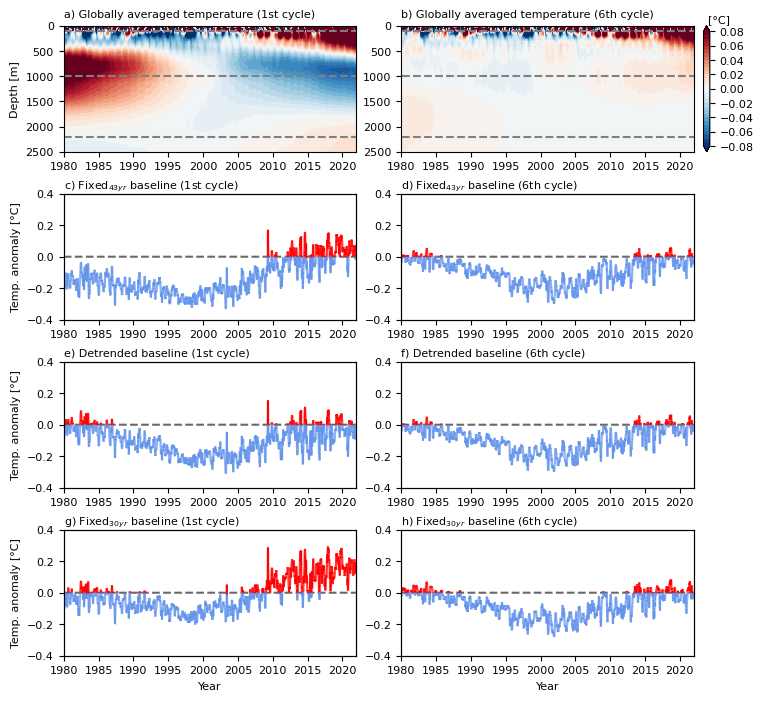

In [22]:
fig = plt.figure(figsize=(7.5,7))
ax0 = fig.add_axes([0.08,0.78,0.39,0.18]); axX = fig.add_axes([0.53,0.78,0.39,0.18])

ax1 = fig.add_subplot([0.08,0.54,0.39,0.18]); axA = fig.add_axes([0.53,0.54,0.39,0.18])
ax2 = fig.add_subplot([0.08,0.3,0.39,0.18]); axB = fig.add_axes([0.53,0.3,0.39,0.18])
ax4 = fig.add_subplot([0.08,0.06,0.39,0.18]); axD = fig.add_axes([0.53,0.06,0.39,0.18])

##
ax0.contourf(dsT_glob.time_counter,  -dsT_glob.deptht,
            (dsT_glob.mean_votemper - dsT_glob.mean_votemper.mean('time_counter')).transpose(),
            cmap='RdBu_r', levels=np.arange(-0.08,0.085,0.005), extend='both')


ax0.hlines(-100,dsT_glob.time_counter[0], dsT_glob.time_counter[-1], colors='grey', linestyles='--')
ax0.hlines(-1000,dsT_glob.time_counter[0], dsT_glob.time_counter[-1], colors='grey', linestyles='--')
ax0.hlines(-2200,dsT_glob.time_counter[0], dsT_glob.time_counter[-1], colors='grey', linestyles='--')

ax0.set_xlim(np.datetime64('1980-01-01'), np.datetime64('2021-12-31'))
ax0.set_ylim(-2500,0)
ax0.set_yticks(np.arange(-2500,1,500))
ax0.set_yticklabels(np.arange(2500,-1,-500))
ax0.set_title('a) Globally averaged temperature (1st cycle)', fontsize=8, loc='left')
ax0.set_ylabel('Depth [m]', fontsize=8)

##
ctf1 = axX.contourf(dsT_glob6.time_counter,  -dsT_glob6.deptht,
            (dsT_glob6.mean_votemper - dsT_glob6.mean_votemper.mean('time_counter')).transpose(),
            cmap='RdBu_r', levels=np.arange(-0.08,0.085,0.005), extend='both')

axX.hlines(-100,dsT_glob.time_counter[0], dsT_glob.time_counter[-1], colors='grey', linestyles='--')
axX.hlines(-1000,dsT_glob.time_counter[0], dsT_glob.time_counter[-1], colors='grey', linestyles='--')
axX.hlines(-2200,dsT_glob.time_counter[0], dsT_glob.time_counter[-1], colors='grey', linestyles='--')

axX.set_xlim(np.datetime64('1980-01-01'), np.datetime64('2021-12-31'))
axX.set_ylim(-2500,0)
axX.set_yticks(np.arange(-2500,1,500))
axX.set_yticklabels(np.arange(2500,-1,-500))
axX.set_title('b) Globally averaged temperature (6th cycle)', fontsize=8, loc='left')

##
coloured_line(T_ano_fixed, ax1)

ax1.plot(time, np.zeros(len(time)), color='dimgrey', linestyle='--', zorder=15)
ax1.set_title(r'c) Fixed$_{43yr}$ baseline (1st cycle)', loc='left', fontsize=8, pad=4)
ax1.set_ylim(-0.4,0.4)
ax1.set_xlim(np.datetime64('1980-01-01'), np.datetime64('2021-12-31'))
ax1.set_ylabel('Temp. anomaly [°C]', fontsize=8)
ax1.set_yticks(np.arange(-0.4,0.41,0.2))

##
coloured_line(T_ano_detrend, ax2)

ax2.plot(time, np.zeros(len(time)), color='dimgrey', linestyle='--', zorder=15)
ax2.set_title('e) Detrended baseline (1st cycle)', loc='left', fontsize=8, pad=4)
ax2.set_ylim(-0.4,0.4)
ax2.set_xlim(np.datetime64('1980-01-01'), np.datetime64('2021-12-31'))
ax2.set_ylabel('Temp. anomaly [°C]', fontsize=8)
ax2.set_yticks(np.arange(-0.4,0.41,0.2))

##
coloured_line(T_ano_WMO, ax4)

ax4.plot(time, np.zeros(len(time)), color='dimgrey', linestyle='--', zorder=15)
ax4.set_title('g) Fixed$_{30yr}$ baseline (1st cycle)', loc='left', fontsize=8, pad=4)
ax4.set_xlabel('Year', fontsize=8)
ax4.set_ylim(-0.4,0.4)
ax4.set_xlim(np.datetime64('1980-01-01'), np.datetime64('2021-12-31'))
ax4.set_ylabel('Temp. anomaly [°C]', fontsize=8)
ax4.set_yticks(np.arange(-0.4,0.41,0.2))

##
coloured_line(T6_ano_fixed, axA)

axA.plot(time, np.zeros(len(time)), color='dimgrey', linestyle='--', zorder=15)
axA.set_title('d) Fixed$_{43yr}$ baseline (6th cycle)', loc='left', fontsize=8, pad=4)
axA.set_ylim(-0.4,0.4)
axA.set_xlim(np.datetime64('1980-01-01'), np.datetime64('2021-12-31'))
axA.set_yticks(np.arange(-0.4,0.41,0.2))

##
coloured_line(T6_ano_detrend, axB)

axB.plot(time, np.zeros(len(time)), color='dimgrey', linestyle='--', zorder=15)
axB.set_title('f) Detrended baseline (6th cycle)', loc='left', fontsize=8, pad=4)
axB.set_ylim(-0.4,0.4)
axB.set_xlim(np.datetime64('1980-01-01'), np.datetime64('2021-12-31'))
axB.set_yticks(np.arange(-0.4,0.41,0.2))

##
coloured_line(T6_ano_WMO, axD)

axD.plot(time, np.zeros(len(time)), color='dimgrey', linestyle='--', zorder=15)
axD.set_xlabel('Year', fontsize=8)
axD.set_title('h) Fixed$_{30yr}$ baseline (6th cycle)', loc='left', fontsize=8,pad=4)
axD.set_ylim(-0.4,0.4)
axD.set_xlim(np.datetime64('1980-01-01'), np.datetime64('2021-12-31'))
axD.set_yticks(np.arange(-0.4,0.41,0.2))

## colorbar  
axcb = fig.add_axes([0.525,0.78,0.48,0.18], frameon=False); axcb.set_xticks([]);  axcb.set_yticks([]);
cb = plt.colorbar(ctf1, ax=[axcb], orientation='vertical') 
cb.set_label('[°C]', y=1.15, labelpad=-25, fontsize=8, rotation=0)

plt.savefig('Baseline_temp-tseries.png', dpi=300)

## Save data for publication

In [23]:
## variable attributes
T6_ano_WMO.attrs['long_name'] = 'Temperature anomaly relative to MHW threshold (6th-cycle)'
T6_ano_WMO.attrs['units'] = 'degC'
T6_ano_detrend.attrs['long_name'] = 'Temperature anomaly relative to MHW threshold (6th-cycle)'
T6_ano_detrend.attrs['units'] = 'degC'
T6_ano_fixed.attrs['long_name'] = 'Temperature anomaly relative to MHW threshold (6th-cycle)'
T6_ano_fixed.attrs['units'] = 'degC'

T_ano_fixed.attrs['long_name'] = 'Temperature anomaly relative to MHW threshold (1st-cycle)'
T_ano_fixed.attrs['units'] = 'degC'
T_ano_detrend.attrs['long_name'] = 'Temperature anomaly relative to MHW threshold (1st-cycle)'
T_ano_detrend.attrs['units'] = 'degC'
T_ano_WMO.attrs['long_name'] = 'Temperature anomaly relative to MHW threshold (1st-cycle)'
T_ano_WMO.attrs['units'] = 'degC'

In [24]:
T_glob_mean = dsT_glob.mean_votemper
T_glob_mean.attrs['long_name'] = 'Global mean temperature (1st-cycle)'

T6_glob_mean = dsT_glob6.mean_votemper
T6_glob_mean.attrs['long_name'] = 'Global mean temperature (6th-cycle)'

In [28]:
## create output dataset
ds_out = xr.Dataset(data_vars={'T6_ano_fixed30yr':T6_ano_WMO.compute(), 'T6_ano_detrend':T6_ano_detrend.compute(), 'T6_ano_fixed43yr':T6_ano_fixed.compute(), 
                               'T_ano_fixed43yr':T_ano_fixed.compute(), 'T_ano_detrend':T_ano_detrend.compute(), 'T_ano_fixed30yr':T_ano_WMO.compute(),
                                'T_glob_mean':T_glob_mean.compute(),'T6_glob_mean':T6_glob_mean.compute()
                                })

In [31]:
## set global attributes
ds_out.attrs['title'] = 'Temperature anomalies global and example grid point'
ds_out.attrs['institution'] = 'GEOMAR Helmholtz Centre for Ocean Research Kiel'
ds_out.attrs['creator_name'] = 'Tobias Schulzki'
ds_out.attrs['creator_email'] = 'tschulzki@geomar.de'
ds_out.attrs['creator_url'] = 'orcid.org/0000-0002-3480-8492'
ds_out.attrs['license'] = 'CC BY 4.0  (https://creativecommons.org/licenses/by/4.0/deed.en)'
ds_out.attrs['keywords'] = 'Temperature, marine heatwaves, VIKING20X, numerical model'
ds_out.attrs['summary'] = 'Created in 2_Baseline_tseries.ipynb'
ds_out.attrs['cdm_data_type'] = 'grid'
ds_out.attrs['processing_level'] = 'Level 4 (numerical simulation output)'
ds_out.attrs['source'] = 'VIKING20X'
ds_out.attrs['pi'] = 'Tobias Schulzki'
ds_out.attrs['pi_contact'] = 'tschulzki@geomar.de'
ds_out.attrs['pi_url'] = 'orcid.org/0000-0002-3480-8492'
ds_out.attrs['institution_id'] = 'https://ror.org/02h2x0161'
ds_out.attrs['research_devision'] = 'Ocean Circulation and Climate Dynamics'
ds_out.attrs['research_unit'] = 'Ocean Dynamics'
ds_out.attrs['project'] = 'iAtlantic, METAscales'
ds_out.attrs['date_created'] = '2025-07-31'
ds_out.attrs['date_modified'] = '2025-07-31'
ds_out.attrs['publisher_name'] = 'GEOMAR Helmholtz Centre for Ocean Research Kiel'
ds_out.attrs['publisher_email'] = 'datamanagement@geomar.de'
ds_out.attrs['naming_authority'] = 'de.geomar'

In [32]:
outpath = '/gxfs_work/geomar/smomw379/Publications/Schulzki2025_MHWs/DATA/'
ds_out.to_netcdf(outpath+'Schulzki_et_al_2025_Figure02.nc')